In [1]:
# Load a full run (model + predictor + loaders + splits) for evaluation
import os, sys, torch
from torch_geometric.transforms import ToUndirected

PROJECT_ROOT = os.path.abspath("..")  # if notebook is in notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.load_graph_data import load_hetero_pt
from src.model_io import load_full_run

# Device selection (prefer CUDA; fall back to CPU to avoid MPS sampler issues)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    # MPS missing CSR conversion for LinkNeighborLoader; use CPU for reliability
    os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')
    DEVICE = torch.device("cpu")
print('Using device:', DEVICE)

MODEL_SAVE_NAME = 'best_model.pt'

# Load and preprocess data (keep consistent with training)
data = load_hetero_pt()
data = ToUndirected()(data)

# Optional: drop nodes/edges to mirror training pipeline
# Which node types do we want to KEEP in the graph?
keep = ['email', 'sender', 'url', 'domain', 'stem', 'body_cluster']  # <- adjust as you like

keep_set = set(keep)

# 1) Delete node types that are NOT in keep
for ntype in list(data.node_types):   # list(...) so we can modify while iterating
    if ntype not in keep_set:
        del data[ntype]

# 2) Delete edge types whose src or dst is NOT in keep
for et in list(data.edge_types):      # et is (src, rel, dst)
    src, rel, dst = et
    if src not in keep_set or dst not in keep_set:
        del data[et]


# Load model, predictor, loaders, splits, and checkpoint metadata
model, predictor, loaders, splits, checkpoint = load_full_run(
    data=data,
    device=DEVICE,
    filename=MODEL_SAVE_NAME,
)
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with val loss {checkpoint['val_loss']:.4f}")


Using device: cpu


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/load_graph_data.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_l

Loaded checkpoint from epoch 52 with val loss 0.8507


### AUROC / Average Precision
These metrics measure ranking quality for link prediction.
- AUROC: probability a random positive scores higher than a random negative (0.5 = random, 1.0 = perfect).
- Average Precision (AP): the weighted average of precision scores at all thresholds — it measures how well the model ranks true edges above false ones, rewarding confident and early correct predictions. (1.0 = perfect ranking, 0.5 = random, lower = poor ranking).


In [2]:
from src.eval_link import collect_auroc_ap_scores
# AUROC/AP (as before)
scores = collect_auroc_ap_scores(DEVICE, model, predictor, loaders['test'])
print("TEST AUROC/AP per relation:")
for et, s in scores.items():
    print(et, s)



TEST AUROC/AP per relation:
('email', 'has_sender', 'sender') {'auroc': 0.5535565759204046, 'ap': 0.30605091449613453}
('email', 'has_url', 'url') {'auroc': 0.9702609207979127, 'ap': 0.8691444960003204}
('email', 'has_domain', 'domain') {'auroc': 0.9705389005433598, 'ap': 0.8833160513424371}
('email', 'has_stem', 'stem') {'auroc': 0.9868785072589951, 'ap': 0.9393601048686936}
('email', 'has_body_cluster', 'body_cluster') {'auroc': 0.9228384422330157, 'ap': 0.7030157769690673}
('sender', 'rev_has_sender', 'email') {'auroc': 0.8633084424752302, 'ap': 0.6380394366630471}
('url', 'rev_has_url', 'email') {'auroc': 0.9759189462166485, 'ap': 0.8842461970467053}
('domain', 'rev_has_domain', 'email') {'auroc': 0.970227309402181, 'ap': 0.8819518619151605}
('stem', 'rev_has_stem', 'email') {'auroc': 0.9850131131422462, 'ap': 0.9297474352080501}
('body_cluster', 'rev_has_body_cluster', 'email') {'auroc': 0.9039817827666722, 'ap': 0.6641712723038418}


### Recall@K (cosine)
For each source node (e.g. an email), rank all possible target nodes (e.g. URLs) by cosine similarity in embedding space. Recall@K is the fraction of source nodes that had at least one *true* connection among their top-K most similar targets. This tells us whether related nodes are close together in embedding space — useful for evaluating embeddings, especially for clustering or retrieval.


In [3]:
from src.eval_link import topk_eval_with_splits
# Recall@K with cosine and larger K (easier for many-to-many like movie→actor)
res_k1_cos = topk_eval_with_splits(DEVICE, model, splits, splits['sup_ets'], K=1, use_dot=False)
print("\nRecall@1 (cosine) per relation:")
for et, m in res_k1_cos.items():
    print(et, m)

res_k10_cos = topk_eval_with_splits(DEVICE, model, splits, splits['sup_ets'], K=10, use_dot=False)
print("\nRecall@10 (cosine) per relation:")
for et, m in res_k10_cos.items():
    print(et, m)

res_k50_cos = topk_eval_with_splits(DEVICE, model, splits, splits['sup_ets'], K=50, use_dot=False)
print("\nRecall@50 (cosine) per relation:")
for et, m in res_k50_cos.items():
    print(et, m)


Recall@1 (cosine) per relation:
('email', 'has_sender', 'sender') {'recall@K': 0.03170028701424599, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 1388}
('email', 'has_url', 'url') {'recall@K': 0.10146341472864151, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 1025}
('email', 'has_domain', 'domain') {'recall@K': 0.08940599858760834, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 1633}
('email', 'has_stem', 'stem') {'recall@K': 0.33287671208381653, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 1460}
('email', 'has_body_cluster', 'body_cluster') {'recall@K': 0.13780918717384338, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 2830}
('sender', 'rev_has_sender', 'email') {'recall@K': 0.0, 'MRR': 0.0, 'K': 1, 'n_eval_sources': 1281}
('url', 'rev_has_url', 'email') {'recall@K': 0.01066666655242443, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 750}
('domain', 'rev_has_domain', 'email') {'recall@K': 0.02079395018517971, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 1058}
('stem', 'rev_has_stem', 'email') {'recall@K': 0.005649717524647713, 'MRR': 1.0,

### Embedding Norm Diagnostics

Computes the L2 norms of email and URL embeddings from the training graph.

Very small norms may indicate vanishing representations (underfitting or over-regularization).

Very large norms can artificially inflate similarity scores and destabilize training.
Use this to check for numerical stability and detect whether embeddings are behaving as expected.

In [4]:
from src.embed import embed_with_graph

import torch
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])
email_vecs = h_train['email']
url_vecs = h_train['url']

print("Email embedding L2 norms:")
print(email_vecs.norm(dim=1).mean(), email_vecs.norm(dim=1).max())

print("URL embedding L2 norms:")
print(url_vecs.norm(dim=1).mean(), url_vecs.norm(dim=1).max())

Email embedding L2 norms:
tensor(1.) tensor(1.0000)
URL embedding L2 norms:
tensor(1.) tensor(1.0000)


### Link Score Distributions & Top-K Qualitative Check
Plots cosine similarity scores between true test edges and random negative pairs.  
A clean separation between the histograms indicates a strong link predictor.

Also retrieves top-K predicted neighbors for a given source node and checks whether any held-out true targets are recovered.
Note: low recall is expected for 1:1 relations like url→email.



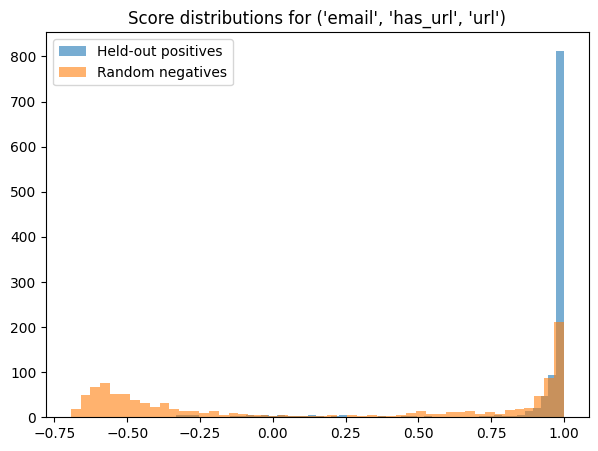

email_id: 222
Top-20 url ids: [1751, 2592, 2381, 934, 34, 1124, 1772, 1427, 2120, 953, 1940, 1129, 1166, 2173, 1053, 971, 1941, 936, 991, 993]
Is held-out true?: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [5]:
import os, sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.embed import embed_with_graph
from src.eval_link import topk_for_source

# --- Embed on the train_graph (leakage-safe) ---
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])

et = ('email', 'has_url', 'url')

# L2-normalize embeddings so dot products ≈ cosine
S = F.normalize(h_train[et[0]], p=2, dim=1)
D = F.normalize(h_train[et[2]], p=2, dim=1)

# For analysis, move everything to CPU to avoid MPS quirks
S = S.cpu()
D = D.cpu()

# Held-out positive edges for this relation (from TEST split)
pos = splits['test_pos'][et]                # [2, E_test]

# Scores for true (held-out) edges
pos_scores = (S[pos[0]] * D[pos[1]]).sum(dim=1).numpy()

# Scores for random negative pairs
g = torch.Generator().manual_seed(0)
neg_src = torch.randint(0, S.size(0), (len(pos_scores),), generator=g)
neg_dst = torch.randint(0, D.size(0), (len(pos_scores),), generator=g)
neg_scores = (S[neg_src] * D[neg_dst]).sum(dim=1).numpy()

plt.figure(figsize=(7, 5))
plt.hist(pos_scores, bins=50, alpha=0.6, label='Held-out positives')
plt.hist(neg_scores, bins=50, alpha=0.6, label='Random negatives')
plt.title(f"Score distributions for {et}")
plt.legend()
plt.show()

# --- Qualitative Top-K example (still fine to use h_train on DEVICE) ---
sources_with_pos = splits['test_pos'][et][0].unique()
src_id = int(sources_with_pos[0])  # pick a valid email id

top_ids, top_scores = topk_for_source(h_train, et, src_id, K=20, cosine=True)
true_dests = set(
    splits['test_pos'][et][1][splits['test_pos'][et][0] == src_id].cpu().tolist()
)
print("email_id:", src_id)
print("Top-20 url ids:", top_ids)
print("Is held-out true?:", [i in true_dests for i in top_ids])


### Recall@K Curves**  
Visualizes how well the model retrieves true neighbors at increasing values of K using cosine similarity.  
Useful for comparing directions and choosing a K for retrieval/clustering.


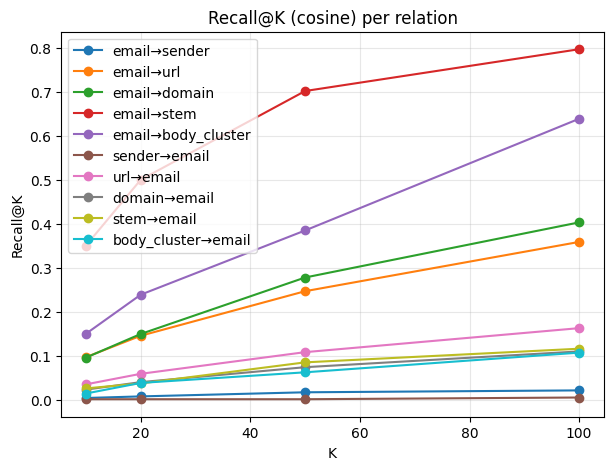

In [6]:
# === Light suggestions: recall curves, cosine vs dot, qualitative Top-K, optional fine-tune ===
import torch, matplotlib.pyplot as plt
import os, sys
PROJECT_ROOT = os.path.abspath("..")  # if notebook is in notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.embed import embed_with_graph
from src.eval_link import collect_auroc_ap_scores, topk_eval_with_splits, topk_for_source, recall_at_k_mrr

# --- 1) Recall@K curves (cosine) ---
K_list = [10, 20, 50, 100]
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])  # leakage-safe embeddings
ets = splits['sup_ets']

recall_curves = {et: [] for et in ets}
for et in ets:
    for K in K_list:
        res = recall_at_k_mrr(h_train, et, splits['test_pos'][et], K=K, use_dot=False)
        recall_curves[et].append(res['recall@K'])

# Plot curves
plt.figure(figsize=(7,5))
for et, vals in recall_curves.items():
    label = f"{et[0]}→{et[2]}"
    plt.plot(K_list, vals, marker='o', label=label)
plt.xlabel("K"); plt.ylabel("Recall@K"); plt.title("Recall@K (cosine) per relation"); plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
